<a href="https://colab.research.google.com/github/ale-camer/Finance/blob/master/Volatility_Smiles_(not_calculated).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q yfinance

In [ ]:
pip install --upgrade matplotlib

In [25]:
def expVolSmiles():

  """ Provide subplots of the volatilty smile in each expiration date of any stock listed in the New York Stock Exchange (NYSE).
  The whole data is download and calculated by Yahoo Finance.
  Only is considered options that were traded in the last business day. """

  try:

    import sys
    import math
    import pandas as pd
    import numpy as np
    import warnings
    warnings.filterwarnings('ignore')
    from tqdm import tqdm
    import yfinance as yf
    import matplotlib.pyplot as plt
    plt.style.use('seaborn')

    a = input("Please, insert the Ticker: ")
    ticker = f'{a}'
    aapl = yf.Ticker(ticker)
    print("Downloading data")
    dates = aapl.options
    S = yf.download(ticker, period = '1d', interval = '1m', progress = False)['Close'][-1]

    calls, puts = pd.DataFrame(), pd.DataFrame()
    for date in tqdm(range(len(dates))):
        try:
            calls = calls.append(aapl.option_chain(dates[date]).calls,ignore_index=True)
            puts = puts.append(aapl.option_chain(dates[date]).puts,ignore_index=True)
        except:
            continue  

    print("Processing data")
    data = pd.concat([calls,puts], axis=0)
    lastTradeDate = pd.Series(pd.DataFrame(data['lastTradeDate'])['lastTradeDate'].apply(lambda a: a.strftime('%d-%m-%Y')).unique()).sort_values(ascending=False)[0]
    data['lastTradeDate'] = data['lastTradeDate'].apply(lambda a: a.strftime('%d-%m-%Y'))
    data = data[data.lastTradeDate == lastTradeDate]
    data['optionType'] = data['contractSymbol'].apply(lambda a: a[10])
    data['expirationDate'] = data['contractSymbol'].apply(lambda a: a[-11:][:2] + '-' + a[-13:][:2] + '-20' + a[-15:][:2])
    data = data[['optionType','expirationDate','impliedVolatility','strike']]

    dates2 = data.expirationDate.value_counts()[data.expirationDate.value_counts() > 10].index
    data = data[data.expirationDate.isin(dates2)]

    prop_data = data.shape[0] / (calls.shape[0] + puts.shape[0])
    if prop_data < 0.5:
        sys.exit()
    else:
        pass

    a, b, c, d = data.impliedVolatility.min(), data.impliedVolatility.max(), data.strike.min(), data.strike.max()

    print("Printing image")
    fig = plt.figure(figsize=(30,15))
    for i in tqdm(range(len(dates))):
        
        datos = data[data['expirationDate'] == data['expirationDate'].unique()[i]]
        call_strikes = datos[datos.optionType == 'C'].strike
        put_strikes = datos[datos.optionType == 'P'].strike
        call_ivs = datos[datos.optionType == 'C'].impliedVolatility
        put_ivs = datos[datos.optionType == 'P'].impliedVolatility
        
        ax = plt.subplot(3,math.ceil(len(dates)/3),i+1)
        plt.xlim([c, d])
        plt.ylim([a, b])
        plt.scatter(call_strikes, call_ivs, marker="o", color = 'green', alpha = 0.25)
        plt.scatter(put_strikes, put_ivs, marker="o", color = 'blue', alpha = 0.25)
        z = np.polyfit(call_strikes, call_ivs, 1^2)
        p = np.poly1d(z)
        plt.plot(call_strikes,p(call_strikes),"r--", color = 'green', linewidth=3, label = 'Calls')
        z = np.polyfit(put_strikes, put_ivs, 1^2)
        p = np.poly1d(z)
        plt.plot(put_strikes,p(put_strikes),"r--", color = 'blue', linewidth=3, label = 'Puts')
        plt.vlines(S, ymin = a, ymax =  b, colors = "red", label = 'Spot', linewidth=3)
        plt.title(f"Expiration: {data.expirationDate.unique()[i]}",fontsize=15)
        ax.yaxis.tick_right()
        
    plt.legend(loc='best', fontsize = 20)
    fig.supxlabel("Strikes", fontsize = 20)
    fig.supylabel("Implied Volatility", fontsize = 20)
    fig.suptitle(f"{ticker.upper()} Volatilty Smiles",fontsize=80)
    fig.tight_layout(rect=(0.01,0,1,1))
    fig.show()

  except:

    print("\n Not enough data available. Please, run the program again and choose another ticker.")

Please, insert the Ticker: amzn


100%|██████████| 17/17 [00:04<00:00,  4.15it/s]


Processing data
Printing image


100%|██████████| 17/17 [00:00<00:00, 35.98it/s]


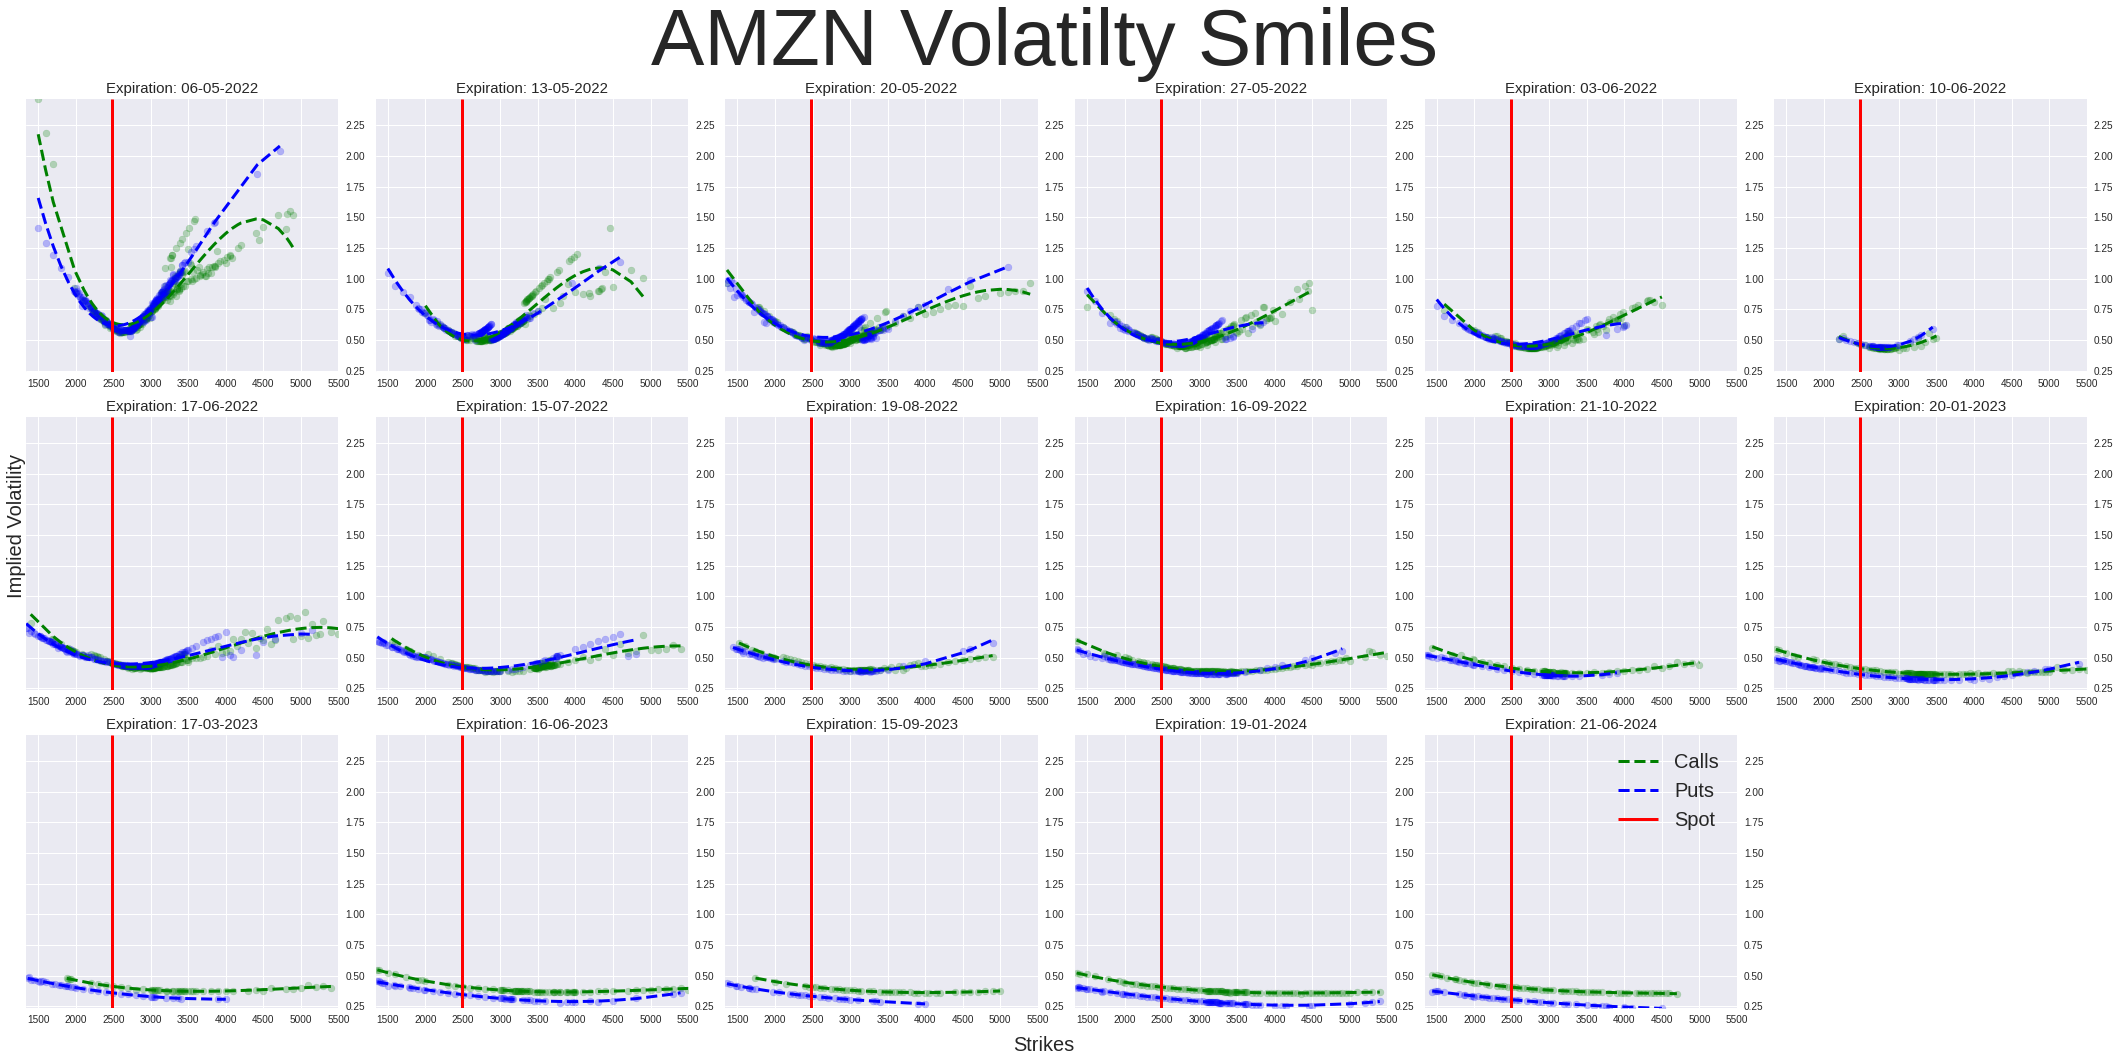

In [28]:
expVolSmiles()